In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold

In [3]:
import pycld2 as cld2


isReliable, textBytesFound, detail = cld2.detect("Arcadian Landscape with Shepherds and Cattle")
detail

(('ENGLISH', 'en', 97, 864.0),
 ('Unknown', 'un', 0, 0.0),
 ('Unknown', 'un', 0, 0.0))

In [13]:
import pandas  as pd
train = pd.read_csv('train.csv')

In [19]:
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train[["title", "title_lang", "likes"]]

,title,title_lang,likes
0,The Avenue of Birches,en,48
1,Struik in bloei,un,2
2,Portret van een vrouw,nl,5
3,A St Bernard Dog,un,100
4,Woelige zee met zeilschepen,nl,7
...,...,...,...
12021,De schilder H.W. Mesdag voor een doek,nl,4
12022,"Kaart van de streek tussen Mannheim en Landau,...",af,0
12023,Storm op het IJ aan het Blauwhoofd van Amsterd...,nl,0
12024,"Het rad van fortuin, ca. 1689",un,14


In [20]:
train['title_lang']

0        en
1        un
2        nl
3        un
4        nl
         ..
12021    nl
12022    af
12023    nl
12024    un
12025    en
Name: title_lang, Length: 12026, dtype: object

In [22]:
df1 = train

In [23]:
df1.to_csv('train_title_lang.csv')

In [35]:

import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()


class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [36]:
BSV = BertSequenceVectorizer() # インスタンス化します

train = pd.read_csv('train.csv')
train['description'] = train['description'].fillna("NaN") # null は代わりのもので埋めます
train['description_feature'] = train['description'].progress_apply(lambda x: BSV.vectorize(x))
train[['object_id', 'description', 'description_feature']].head()

100%|██████████| 12026/12026 [2:15:37<00:00,  1.48it/s] 


,object_id,description,description_feature
0,0011d6be41612ec9eae3,NaN,"[-0.04250159, 0.036861505, 0.039393608, 0.0547..."
1,0012765f7a97ccc3e9e9,NaN,"[-0.04250159, 0.036861505, 0.039393608, 0.0547..."
2,0017be8caa87206532cb,"Portret van eenvrouw, zittend naast een tafel.","[-0.63844216, 0.12233404, 0.16228917, -0.46431..."
3,00181d86ff1a7b95864e,"Een sint-bernardshond, staand in een landschap...","[-0.6219215, -0.25778952, 0.13090691, -0.17220..."
4,001c52ae28ec106d9cd5,Woelige zee met zeilschepen.,"[-0.82783353, 0.09303975, -0.10044706, -0.4505..."


In [ ]:
train.to_csv("train_BEAT.csv",float_format='%.18f')

In [ ]:
train = pd.read_csv("train_BEAT.csv")

In [12]:
def create_input_array_pca(input_df):
    features = []
    for array in input_df['description_feature']:
        features.append(array)
    return pd.DataFrame(features).values.astype(np.float32)

In [ ]:
x = create_input_array_pca(description_feature_df)
x.shape, x.dtype

In [37]:
from sklearn.decomposition import PCA

In [38]:
def result_description_pca(N):
    pca = PCA(n_components=N).fit(x)
    transformed = pca.transform(x)
    for n in range(N):
        print(f'第 {n+1} 主成分：{pca.explained_variance_ratio_[n]}')
    return pd.DataFrame(transformed)

In [ ]:
result_feature = result_description_pca(N=2)
plt.scatter(result_feature[0], result_feature[1]);

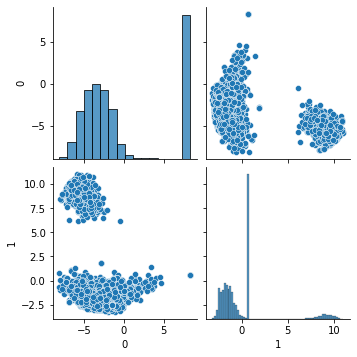

In [51]:
sns.pairplot(result_feature);

In [53]:
result_feature.columns = ["PCA1","PCA2"]

In [54]:
result_feature

,PCA1,PCA2
0,8.335306,0.610749
1,8.335306,0.610749
2,-1.475386,-2.416383
3,1.409902,-1.233963
4,-1.516180,-2.953954
...,...,...
12021,8.335306,0.610749
12022,-4.618852,-1.087324
12023,-2.262537,-1.980101
12024,-5.922932,9.162234


In [63]:
df2 = pd.concat([description_feature_df,result_feature],axis = 1)

In [64]:
df2.to_csv('train_PCA.csv')

In [65]:
from sklearn.decomposition import TruncatedSVD

In [66]:
def result_description_svd(N):
    svd = TruncatedSVD(n_components=N).fit(x)
    transformed = svd.transform(x)
    for n in range(N):
        print(f'第 {n+1} 成分：{svd.explained_variance_ratio_[n]}')
    return pd.DataFrame(transformed)


第 1 成分：0.08421853184700012
第 2 成分：0.5636075139045715


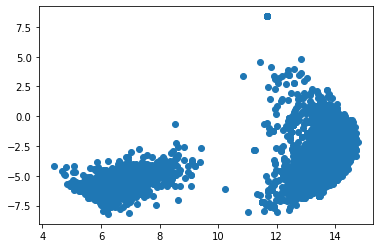

In [70]:
result_feature = result_description_svd(N=2)
plt.scatter(result_feature[0], result_feature[1]);

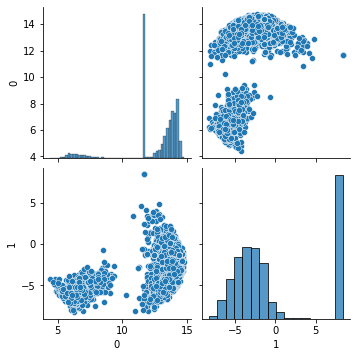

In [68]:
sns.pairplot(result_feature);

In [73]:
result_feature.columns = ["SVD1","SVD2"]

In [75]:
df3 = pd.concat([description_feature_df,result_feature],axis = 1)